<a href="https://colab.research.google.com/github/chdhatri/Anamoly-Detection/blob/main/anamoly_detection_mrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import torch.utils.data
import cv2
import torchvision.models.segmentation
import torch
import os
from PIL import Image
from torch.optim import lr_scheduler
from torchvision.datasets.folder import pil_loader
from torch.utils.data import Dataset
from torchsummary import summary
import glob

In [ ]:
!git clone https://github.com/abin24/Magnetic-tile-defect-datasets..git


Cloning into 'Magnetic-tile-defect-datasets.'...
remote: Enumerating objects: 2646, done.
remote: Total 2646 (delta 0), reused 0 (delta 0), pack-reused 2646
Receiving objects: 100% (2646/2646), 50.04 MiB | 10.02 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [ ]:
!rm -rf Magnetic-tile-defect-datasets./MT_Free/

In [ ]:
!rm -rf Magnetic-tile-defect-datasets./MT_Uneven/

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import cv2
import pandas as pd
import json
import logging
import warnings
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline 
%load_ext tensorboard
plt.ion()
warnings.filterwarnings('ignore')
writer = SummaryWriter()
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113


**Partitioning the data into train and test**

**bold text**

In [ ]:
def partition():
  split_ratio = [0.7, 0.15]
  data_path = {}
  partition = {'train', 'test'}

  classes = ['Blowhole', 'Break','Crack','Fray']

  train = {}
  valid = {}
  test = {}

  for c in classes:
    data_path[c] = glob.glob('/content/Magnetic-tile-defect-datasets./MT_' + c + '/Imgs/*.jpg',recursive=True) 
    random.shuffle(data_path[c])
    
    l = len(data_path[c])
    split = int(split_ratio[0]*l)
    split1 = int(split_ratio[0]*l) + int(split_ratio[1]*l)
    train[c] = data_path[c][:split]
    valid[c] = data_path[c][split: split1]
    test[c] = data_path[c][split1:]

    print("train:",len(train[c]))
    print("valid:", len(valid[c]))
    print("test:", len(test[c]))


  return train, valid, test  
    

In [ ]:

train, valid, test = partition()

train: 80
valid: 17
test: 18
train: 59
valid: 12
test: 14
train: 39
valid: 8
test: 10
train: 22
valid: 4
test: 6


In [ ]:
print(test['Break'])

['/content/Magnetic-tile-defect-datasets./MT_Break/Imgs/exp6_num_98402.jpg', '/content/Magnetic-tile-defect-datasets./MT_Break/Imgs/exp1_num_284482.jpg', '/content/Magnetic-tile-defect-datasets./MT_Break/Imgs/exp3_num_98116.jpg', '/content/Magnetic-tile-defect-datasets./MT_Break/Imgs/exp3_num_148977.jpg', '/content/Magnetic-tile-defect-datasets./MT_Break/Imgs/exp5_num_304345.jpg', '/content/Magnetic-tile-defect-datasets./MT_Break/Imgs/exp1_num_194173.jpg', '/content/Magnetic-tile-defect-datasets./MT_Break/Imgs/exp3_num_194220.jpg', '/content/Magnetic-tile-defect-datasets./MT_Break/Imgs/exp2_num_116961.jpg', '/content/Magnetic-tile-defect-datasets./MT_Break/Imgs/exp3_num_77583.jpg', '/content/Magnetic-tile-defect-datasets./MT_Break/Imgs/exp6_num_356817.jpg', '/content/Magnetic-tile-defect-datasets./MT_Break/Imgs/exp6_num_26244.jpg', '/content/Magnetic-tile-defect-datasets./MT_Break/Imgs/exp1_num_26106.jpg', '/content/Magnetic-tile-defect-datasets./MT_Break/Imgs/exp6_num_117060.jpg', '/c

In [ ]:
def mask_to_border(mask):
    h, w = mask.shape
    border = np.zeros((h, w))
    padded_binary_mask = np.pad(mask, pad_width=1, mode='constant', constant_values=0)
    contours = find_contours(padded_binary_mask, 128)
    contours = np.subtract(contours, 1)

    len_contours = len(contours)

    for contour in contours:
        
        for c in contour:
            x = int(c[0])
            y = int(c[1])
            border[x][y] = 255
    return border, len_contours  

''' convert mask to bbox '''
def mask_to_bbox(mask, class_name):
    bboxes = []
    h, w = mask.shape
    border, len_contour = mask_to_border(mask)   
    lbl = label(border)  
    props = regionprops(lbl)

    for prop in props:
        x1 = prop.bbox[1]  #xmin
        y1 = prop.bbox[0]  #ymin

        x2 = prop.bbox[3]  #xmax
        y2 = prop.bbox[2]  #yman


       
        area = int((x2 - x1) * (y2 - y1))
        #print("Area of bbox", area)
        if (area > 15):
            bboxes.append([x1, y1, x2, y2, class_name])


    return bboxes

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
label_map = {
    "Blowhole": "0",
    "Break": "1",
    "Crack": "2",
    "Fray": "3"
}

In [ ]:
from skimage.measure import label, regionprops, find_contours
import albumentations as A
IMAGE_SIZE = 512

class SurfaceDefectDetection(Dataset):
  def __init__(self, data=train, is_Train = True, is_valid= False, is_Test= False,transforms=None):
    self.data = []
    self.masks = []
    self.obj_labels = []
    self.annotations = []
    self.transforms  = []

    if transforms!=None:
        self.transforms.append(transforms)

    classes = ['Blowhole', 'Break', 'Crack', 'Fray']
    for c in classes:
      #print(c)
      for file in data[c]:
        file_name = file.split('/')[-1].split('.')[0]
        mask_file = file.split('.jpg')[0]+".png"
        #print(file_name)
        img = cv2.imread(file)[:,:,::-1]
        height, width, channels = img.shape

        mask = Image.open(mask_file)
        mask = np.array(mask)
        #mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

        border_mask, len_contours = mask_to_border(mask)
        bboxes = mask_to_bbox(mask, int(label_map[c]))

         # skip unannotated images
        if len(bboxes) == 0: 
          continue

        transform = A.Compose(
          [
            A.Resize(width=512, height=512),
            
            
            
            
        ], bbox_params=A.BboxParams(format="pascal_voc", min_area=30,
                                min_visibility=0.3, label_fields=[]))
        
        transformed = transform(
              image=img, 
              mask = mask,
              bboxes=bboxes)
        transformed_image = transformed['image']
        transformed_mask = transformed["mask"]
        transformed_bboxes = transformed['bboxes']

        #print(transformed_image.shape)

        if is_Train:
          create_dir(r"/content/Magnetic-tile-defect-datasets./Augmented_data/train/Imgs")
          create_dir(r"/content/Magnetic-tile-defect-datasets./Augmented_data/train/Masks")
          aug_img_path = f"/content/Magnetic-tile-defect-datasets./Augmented_data/train/Imgs/{file_name}.jpg"
          aug_mask_path = f"/content/Magnetic-tile-defect-datasets./Augmented_data/train/Masks/{file_name}.png"
        elif is_valid:
           create_dir(r"/content/Magnetic-tile-defect-datasets./Augmented_data/val/Imgs")
           create_dir(r"/content/Magnetic-tile-defect-datasets./Augmented_data/val/Masks")
           aug_img_path = f"/content/Magnetic-tile-defect-datasets./Augmented_data/val/Imgs/{file_name}.jpg"
           aug_mask_path = f"/content/Magnetic-tile-defect-datasets./Augmented_data/val/Masks/{file_name}.png"
        else:
           create_dir(r"/content/Magnetic-tile-defect-datasets./Augmented_data/test/Imgs")
           create_dir(r"/content/Magnetic-tile-defect-datasets./Augmented_data/test/Masks")
           aug_img_path = f"/content/Magnetic-tile-defect-datasets./Augmented_data/test/Imgs/{file_name}.jpg"
           aug_mask_path = f"/content/Magnetic-tile-defect-datasets./Augmented_data/test/Masks/{file_name}.png"

        cv2.imwrite(aug_img_path, transformed_image)
        cv2.imwrite(aug_mask_path, transformed_mask)

         # save required information
        self.data.append(aug_img_path)
        self.masks.append(aug_mask_path)
        self.annotations.append([x[:-1] for x in transformed_bboxes])
        self.obj_labels.append([x[-1] for x in transformed_bboxes])

  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, mask_path, annotation, obj_labels = self.data[idx], self.masks[idx], self.annotations[idx], self.obj_labels[idx]
        N = len(annotation)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        
        for i in self.transforms:
          image = i(image)
          mask = i(mask)

       

        #print("Image shape:", w, h)

        # define requirements for input to model
        image_id = torch.tensor([idx])
        labels = torch.as_tensor(obj_labels, dtype=torch.int64)
        #print("labels:", labels)
        boxes = torch.as_tensor(annotation, dtype=torch.float32)
        masks = torch.as_tensor(mask, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((N,), dtype=torch.int64)

        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = mask
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd   
        

       
       
        return image.double(), target

  def __len__(self):
        return len(self.data)



              


    

In [ ]:
!rm -rf /content/Magnetic-tile-defect-datasets./Augmented_data

In [ ]:
!git clone 'https://github.com/pytorch/vision.git'

Cloning into 'vision'...
remote: Enumerating objects: 224895, done.
remote: Counting objects: 100% (5158/5158), done.
remote: Compressing objects: 100% (438/438), done.
remote: Total 224895 (delta 4792), reused 5032 (delta 4708), pack-reused 219737
Receiving objects: 100% (224895/224895), 453.00 MiB | 31.19 MiB/s, done.
Resolving deltas: 100% (203606/203606), done.


In [ ]:
!pwd

/content


In [ ]:


# use our dataset and defined transformations
dataset = SurfaceDefectDetection(train,
                                is_Train=True,
                                 is_valid=False,
                                 is_Test=False,
                                 transforms=torchvision.transforms.ToTensor())
dataset_valid = SurfaceDefectDetection(valid,
                                is_Train=False,
                                is_valid=True,
                                is_Test=False,
                                transforms=torchvision.transforms.ToTensor())


dataset_test = SurfaceDefectDetection(valid,
                                is_Train=False,
                                is_valid=False,
                                is_Test=True,
                                transforms=torchvision.transforms.ToTensor())



In [ ]:
images, targets = dataset[0]


In [ ]:
# define training and validation data loaders
from vision.references.detection import utils
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid, batch_size=2, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor



num_classes = 1 + 4
# load an instance segmentation model pre-trained pre-trained on COCO
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# now get the number of input features for the mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                    hidden_layer,
                                                    num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model=model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
!cp /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth /content/Magnetic-tile-defect-datasets./Models/

In [ ]:
cp  /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth /content/Magnetic-tile-defect-datasets./Models

In [ ]:
# run incase tensorboard needs to be refrehsed
from datetime import datetime
now = datetime.now()
!rm -rf ./runs/
%reload_ext tensorboard
writer = SummaryWriter()

In [ ]:
import tqdm as tqdm
import matplotlib.pyplot as plt
# Perform training loop for n epochs
loss_list = []
n_epochs = 5
model.train()
for epoch in tqdm.tqdm(range(n_epochs)):
    loss_epoch = []
    iteration=1
    for images,targets in tqdm.tqdm(data_loader):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        model=model.double()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()       
        optimizer.step()
        # print('loss:', losses.item())
        # loss_epoch.append(losses.item())
        loss_epoch.append(losses.item())
        # Plot loss every 10th iteration

        iteration+=1
    loss_epoch_mean = np.mean(loss_epoch) 
    loss_list.append(loss_epoch_mean) 
    # loss_list.append(loss_epoch_mean)    
    print("Average loss for epoch = {:.4f} ".format(loss_epoch_mean))


   

 20%|██        | 1/5 [21:14<1:24:56, 1274.13s/it]

Average loss for epoch = 0.4169 



 40%|████      | 2/5 [42:31<1:03:48, 1276.25s/it]

Average loss for epoch = 0.3821 



 60%|██████    | 3/5 [1:03:48<42:33, 1276.52s/it]

Average loss for epoch = 0.3521 



 80%|████████  | 4/5 [1:25:05<21:16, 1276.68s/it]

Average loss for epoch = 0.3125 



100%|██████████| 5/5 [1:46:24<00:00, 1276.90s/it]

Average loss for epoch = 0.2921 


In [ ]:
loss_list

[0.4168564888784563,
 0.3821436175496433,
 0.35210860223498414,
 0.3124626321385223,
 0.2920605676793864]

In [ ]:
save_path = '/content/Magnetic-tile-defect-datasets./Models/'+str('model1.pth')
torch.save(model.state_dict(), save_path)

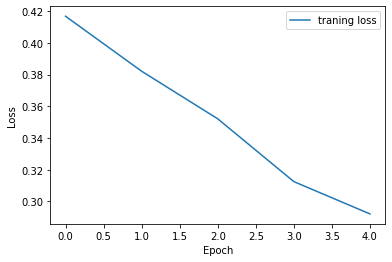

In [ ]:
# Plot training loss
plt.plot(list(range(n_epochs)), loss_list, label='traning loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Load previously trained model 
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [ ]:
model.to(device)# move model to the right devic
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

In [ ]:
len(data_loader_test)

21

In [ ]:
test_path= r'/content/Magnetic-tile-defect-datasets./Augmented_data/test/Imgs/exp6_num_136770.jpg'

In [ ]:
images, targets=next(iter(data_loader_valid))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model=model.double()
model.eval()
output = model(images)

In [ ]:
print(len(output[0]['labels']))

14


In [ ]:
images,labels=next(iter(data_loader_test))

In [ ]:
print(len(images))

2


In [ ]:
import matplotlib.patches as mpatches
from matplotlib import patches
def view(images,labels,n=2,std=1,mean=0):
    figure = plt.figure(figsize=(15,10))
    images=list(images)
    labels=list(labels)
    for i in range(n):
        out=torchvision.utils.make_grid(images[i])
        inp=out.cpu().numpy().transpose((1,2,0))
        inp=np.array(std)*inp+np.array(mean)
        inp=np.clip(inp,0,1)  
        ax = figure.add_subplot(2,2, i + 1)
        ax.imshow(images[i].cpu().numpy().transpose((1,2,0)))
        l=labels[i]['boxes'].cpu().numpy()
        s=labels[i]['scores'].cpu().numpy()
        m = labels[i]['masks'].cpu().numpy() 
        #print("scores:", s)
        #print("masks:",m)
        l[:,2]=l[:,2]-l[:,0]
        l[:,3]=l[:,3]-l[:,1]
        for j in range(len(l)):
            ax.add_patch(patches.Rectangle((l[j][0],l[j][1]),l[j][2],l[j][3],linewidth=1.5,edgecolor='r',facecolor='none')) 



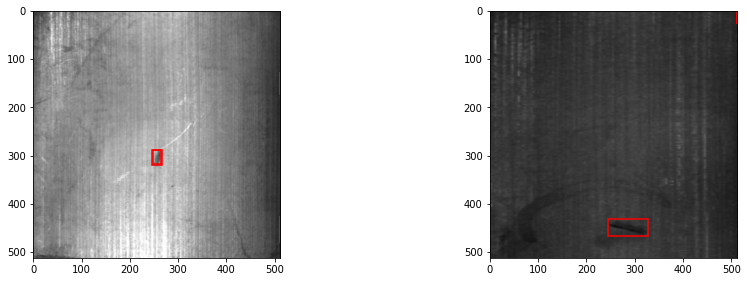

In [ ]:
# Look at some of the images and predicted bbox's after training

images, targets=next(iter(data_loader_test))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model=model.double()
model.eval()
output = model(images)

with torch.no_grad():
    view(images, output, 2)

In [ ]:
print(len(output[0]['boxes']))
print(len(output[0]['scores']))

14
14


In [ ]:
output[0]['boxes'][0]

tensor([511.9888, 129.4043, 512.0000, 173.7526], device='cuda:0',
       dtype=torch.float64, grad_fn=<SelectBackward0>)

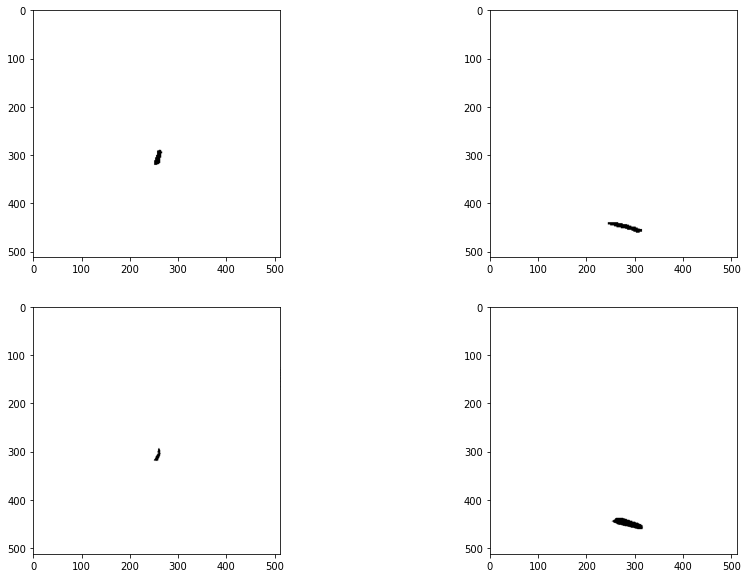

In [ ]:
def view_mask(targets, output, n=2, cmap='Greys'):
    figure = plt.figure(figsize=(15,10))
    for i in range(n):
      # plot target (true) masks
      target_im = targets[i]['masks'][0].cpu().detach().numpy()
      for k in range(len(targets[i]['masks'])):
        target_im2 = targets[i]['masks'][k].cpu().detach().numpy()
        target_im2[target_im2>0.5] = 1
        target_im2[target_im2<0.5] = 0
        target_im = target_im+target_im2

      target_im[target_im>0.5] = 1
      target_im[target_im<0.5] = 0
      ax = figure.add_subplot(2,2, i+1)
      ax.imshow(target_im, cmap=cmap)
      # Plot output (predicted) masks
      output_im = output[i]['masks'][0][0, :, :].cpu().detach().numpy()
      for k in range(len(output[i]['masks'])):
        output_im2 = output[i]['masks'][k][0, :, :].cpu().detach().numpy()
        output_im2[output_im2>0.5] = 1
        output_im2[output_im2<0.5] = 0
        output_im = output_im+output_im2

      output_im[output_im>0.5] = 1
      output_im[output_im<0.5] = 0
      ax = figure.add_subplot(2,2, i+3)
      ax.imshow(output_im, cmap=cmap)
      ax.imshow(output_im, cmap=cmap)

view_mask(targets, output, n=2)


In [ ]:
def get_prediction(img_path, confidence):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
      - confidence - threshold to keep the prediction or not
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
        ie: eg. segment of cat is made 1 and rest of the image is made 0
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  # print(pred[0]['labels'].numpy().max())
  pred_class = [COCO_CLASS_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class